In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, poisson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
df = pd.read_csv("train_strokes.csv")
df = df.drop(['id'], axis=1)


In [3]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

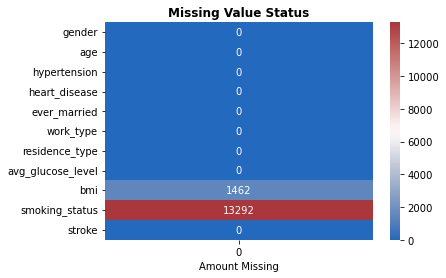

In [4]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()


In [5]:
df = df.drop(df[df['gender'] == 'Other'].index)

In [6]:
# the fact that both smoking status and BMI with NaN values represents such a large subset of the stroke data is likely
# meaningful - stroke patients arent being measured for weight when they come in or asked about smoking habits.
# additionally, they could have poor medical care
# for whatever reason, given this is important so we cannot impute. Instead I unfortunately removed these features.

In [7]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['residence_type'] = le.fit_transform(df['residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])





In [8]:



oldX, y = df.drop('stroke', axis=1).values, df['stroke'].values
encoder = OneHotEncoder(handle_unknown='ignore') 
ct = ColumnTransformer([('encoder', encoder, [0, 4, 5, 6])], remainder='passthrough') 
X = ct.fit_transform(oldX)


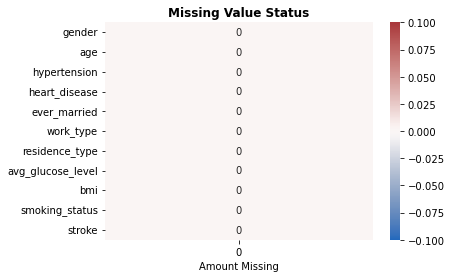

In [9]:

df.bmi.replace(to_replace=np.nan, value=df.bmi.mean(),inplace=True)
df.smoking_status.replace(to_replace=np.nan, value=df.smoking_status.mean(),inplace=True)
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit_transform(X))
print(X)

[[-1.20334391  1.20334391  1.34434345 ... -0.21725232 -1.3648686
   1.28633364]
 [-1.20334391  1.20334391 -0.74385753 ... -0.38332112  1.36354144
  -0.53987964]
 [ 0.83101763 -0.83101763  1.34434345 ...  0.14851654 -1.41634804
   1.28633364]
 ...
 [ 0.83101763 -0.83101763 -0.74385753 ... -0.29100913  0.03794599
  -1.45298628]
 [-1.20334391  1.20334391 -0.74385753 ... -0.12354869  0.59134992
  -0.53987964]
 [ 0.83101763 -0.83101763 -0.74385753 ... -0.58000596 -1.03025228
  -0.53987964]]
[[  0.     1.     1.   ...  95.12  18.     3.  ]
 [  0.     1.     0.   ...  87.96  39.2    1.  ]
 [  1.     0.     1.   ... 110.89  17.6    3.  ]
 ...
 [  1.     0.     0.   ...  91.94  28.9    0.  ]
 [  0.     1.     0.   ...  99.16  33.2    1.  ]
 [  1.     0.     0.   ...  79.48  20.6    1.  ]]


oldX, y = df.drop('stroke', axis=1).values, df['stroke'].values
encoder = OneHotEncoder(handle_unknown='ignore')
ct = ColumnTransformer([('encoder', encoder, [0, 4, 5, 6])], remainder='passthrough')
X = ct.fit_transform(oldX)

In [11]:
df=df.drop(df['stroke']).values

In [12]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2)
df_pred=km.fit_predict(df)
df_pred


array([0, 0, 1, ..., 0, 0, 0])

In [13]:
df.shape

(43387, 11)

In [14]:
# over and under sampling
print('Before UnderSampling, counts of label 1: {}'.format(sum(df_pred==1)))
print('Before UnderSampling, counts of label 0: {} \n'.format(sum(df_pred==0)))

from imblearn.combine import SMOTEENN


smote_enn = SMOTEENN(random_state=0)
X_res, y_res = smote_enn.fit_resample(df, df_pred)

print('After UnderSampling, the shape of train_x: {}'.format(X_res.shape))
print('After Undersampling, the shape of train_y: {}'.format(y_res.shape))

print('After UnderSampling, counts of label 1: {}'.format(sum(y_res == 1)))
print('After UnderSampling, counts of label 0: {}'.format(sum(y_res == 0)))





Before UnderSampling, counts of label 1: 5835
Before UnderSampling, counts of label 0: 37552 

After UnderSampling, the shape of train_x: (75002, 11)
After Undersampling, the shape of train_y: (75002,)
After UnderSampling, counts of label 1: 37544
After UnderSampling, counts of label 0: 37458


In [15]:
print('Before OverSampling, counts of label 1: {}'.format(sum(y_res==1)))
print('Before OverSampling, counts of label 0: {} \n'.format(sum(y_res==0)))

from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=0)
X_res, y_res = smote_tomek.fit_resample(X_res, y_res)

print('After OverSampling, the shape of train_x: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_res.shape))
print('After OverSampling, counts of label 1: {}'.format(sum(y_res == 1)))
print('After OverSampling, counts of label 0: {}'.format(sum(y_res == 0)))

Before OverSampling, counts of label 1: 37544
Before OverSampling, counts of label 0: 37458 

After OverSampling, the shape of train_x: (75088, 11)
After OverSampling, the shape of train_y: (75088,)
After OverSampling, counts of label 1: 37544
After OverSampling, counts of label 0: 37544


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=0)
print('Number transations x_train df',X_train.shape)
print('Number transations x_test df',X_test.shape)
print('Number transations y_train df',y_train.shape)
print('Number transations y_test df',y_test.shape)

models = []
models.append(['XGBClassifier',XGBClassifier(learning_rate=0.1,objective='binary:logistic',random_state=0,eval_metric='mlogloss')])
models.append(['KNeigbors',KNeighborsClassifier()])
models.append(['RandomForest',RandomForestClassifier(random_state=0)])

lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracies = cross_val_score(estimator= model, X = X_train,y = y_train, cv=10)

# k-fOLD Validation
    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    print(models[m][0],':')
    print(cm)
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))
    print('')
    print('K-Fold Validation Mean Accuracy: {:.2f} %'.format(accuracies.mean()*100))
    print('')
    print('Standard Deviation: {:.2f} %'.format(accuracies.std()*100))
    print('')
    print('ROC AUC Score: {:.2f} %'.format(roc))
    print('')
    print('Precision: {:.2f} %'.format(precision))
    print('')
    print('Recall: {:.2f} %'.format(recall))
    print('')
    print('F1 Score: {:.2f} %'.format(f1))
    print('-'*40)
    print('')
    lst_2.append(models[m][0])
    lst_2.append(accuracy_score(y_test,y_pred)*100)
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)



Number transations x_train df (52561, 11)
Number transations x_test df (22527, 11)
Number transations y_train df (52561,)
Number transations y_test df (22527,)
XGBClassifier :
[[11162     5]
 [    0 11360]]
Accuracy Score:  0.999778044124828

K-Fold Validation Mean Accuracy: 99.98 %

Standard Deviation: 0.04 %

ROC AUC Score: 1.00 %

Precision: 1.00 %

Recall: 1.00 %

F1 Score: 1.00 %
----------------------------------------

KNeigbors :
[[11159     8]
 [    0 11360]]
Accuracy Score:  0.9996448705997247

K-Fold Validation Mean Accuracy: 99.95 %

Standard Deviation: 0.04 %

ROC AUC Score: 1.00 %

Precision: 1.00 %

Recall: 1.00 %

F1 Score: 1.00 %
----------------------------------------

RandomForest :
[[11161     6]
 [    1 11359]]
Accuracy Score:  0.9996892617747591

K-Fold Validation Mean Accuracy: 99.97 %

Standard Deviation: 0.02 %

ROC AUC Score: 1.00 %

Precision: 1.00 %

Recall: 1.00 %

F1 Score: 1.00 %
----------------------------------------



In [18]:

"""MODEL TUNING"""

grid_models1 = [(XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error']}])]
grid_models2 = [(KNeighborsClassifier(),[{'n_neighbors':[5,7,8,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}])]  
grid_models3 = [(RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}])]




In [19]:
for i,j in grid_models1:
    clf1 = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv = 10)
    clf1.fit(X_train,y_train)
    best_accuracy = clf1.best_score_
    best_param = clf1.best_params_
    print(' {}: \n Best Accuracy: {:.2f} %'.format(i,best_accuracy*100))
    print('')
    print('-'*25)
    print('')
    
    
for i,j in grid_models2:
    clf2 = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv = 10)
    clf2.fit(X_train,y_train)
    best_accuracy = clf2.best_score_
    best_param = clf2.best_params_
    print(' {}: \n Best Accuracy: {:.2f} %'.format(i,best_accuracy*100))
    print('')
    print('-'*25)
    print('')
    
for i,j in grid_models3:
    clf3 = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv = 10)
    clf3.fit(X_train,y_train)
    best_accuracy = clf3.best_score_
    best_param = clf3.best_params_
    print(' {}: \n Best Accuracy: {:.2f} %'.format(i,best_accuracy*100))
    print('')
    print('-'*25)
    print('')

 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None): 
 Best Accuracy: 99.98 %

-------------------------

 KNeighborsClassifier(): 
 Best Accuracy: 99.95 %

-------------------------

 RandomForestClassifier(): 
 Best Accuracy: 99.97 %

-------------------------



In [20]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('XGB', clf1), ('KNN', clf2), ('RF', clf3)], voting='hard')

[[11161     6]
 [    1 11359]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11167
           1       1.00      1.00      1.00     11360

    accuracy                           1.00     22527
   macro avg       1.00      1.00      1.00     22527
weighted avg       1.00      1.00      1.00     22527

ROC AUC score: 0.9997761260857885
Accuracy Score:  0.999778044124828


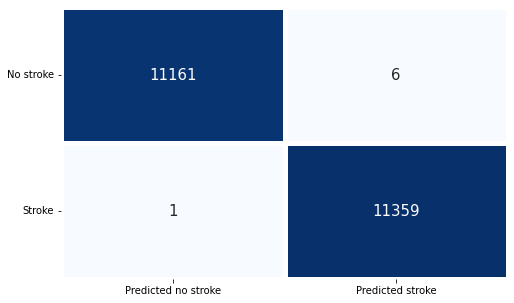

In [21]:
# for other linear models would have used predict_proba
pipe = model.fit(X_train, y_train)
predictions = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, predictions))
print(f'ROC AUC score: {roc_auc_score(y_test, predictions)}')
print('Accuracy Score: ',accuracy_score(y_test, predictions))
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

pipe=model.fit(X_res,y_res)

In [22]:
dump(pipe, 'savedModel.joblib') 

['savedModel.joblib']

In [23]:
dump(ct, 'savedColumnTransformer.joblib')

['savedColumnTransformer.joblib']

In [24]:
from sklearn.metrics import classification_report

predictions = pipe.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11167
           1       1.00      1.00      1.00     11360

    accuracy                           1.00     22527
   macro avg       1.00      1.00      1.00     22527
weighted avg       1.00      1.00      1.00     22527



In [25]:
def gather_user_data_output_result(pipe, ct):
    gender = input("please input gender as either: 'male' or 'female'")
    age = float(input("please input age as float"))
    hypertension = int(input("please input if you have hypertension as either 1 for yes or 0 for no"))
    heartdisease = int(input("please input if you have heart disease as either 1 for yes or 0 for no"))
    ever_married = input("please input if you have ever been married as either 'Yes' or 'No'")
    work_type = input("please input your current work type as one of the following: 'children', 'Private', 'Never_worked', 'Govt_job', 'Self-employed'")
    Residence_type = input("please input your residence type as either 'Rural' or 'Urban'")
    avg_glucose_level = float(input("please input your average glucose level as a float"))
    bmi = float(input("please input your bmi as a float"))
    smoking_status= input("please input your smoking_status as one of the following: 'formerly_smoked as 0', 'smokes as 1', 'Never_smoked as 1'")
    
    row = [gender, age, hypertension, heartdisease, ever_married, work_type, Residence_type, avg_glucose_level,bmi,smoking_status]
    row = ct.transform([row])
    result = pipe.predict(row)
    result = result[0]
    if result == 0:
        print("According to the model you will likely not have a stroke.")
    elif result == 1:
        print("According to the model you may likely  have a stroke. Please see a doctor")
    return result
    

               

In [ ]:
gather_user_data_output_result(pipe, ct)

In [ ]:
df.head(10)


In [ ]:
S